In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getEPPA(ell, ndays, case):
    fldStr = {'orig': '',
               'crseAtm':'_crseAtm',
               'Recipe':'_Recipe'
                }
    
    fileStr = {'orig': '',
               'crseAtm':'_crseAtm2P5deg',
               'Recipe':'_crseAtm2P5degRecipe'
                }
    
    fldLoc = '/pscratch/sd/s/srai/ROMSwithWRF/run/output0p25deg{0:s}/{1:d}km/'.format(fldStr[case], ell)
    EPPA = np.zeros((ndays, 434, 1120), dtype=float)
    for day in range(ndays):
        fileName = 'ROMS_withWRF_p25degC_data{2:s}_LP_filteredAt_{0:04d}_timeAt{1:03d}.nc'.format(ell, day, fileStr[case])
        ds = Dataset(fldLoc + fileName)
        ut = np.array(ds.variables['tauxUo'])
        vt = np.array(ds.variables['tauyVo'])
        uo = np.array(ds.variables['uo'])
        vo = np.array(ds.variables['vo'])
        tx = np.array(ds.variables['taux'])
        ty = np.array(ds.variables['tauy'])
        EPPA[day,:,:] = (ut - tx*uo) +(vt - ty*vo)
    return EPPA

In [3]:
gridDS = Dataset('/pscratch/sd/s/srai/ROMSwithWRF/run/input/ROMSgrid.nc')
UAREA = np.array(gridDS.variables['UAREA'])
gridDS.variables.keys()

# kmtDS = Dataset('/gpfs/fs1/home/srai6/Desktop/SecondEddyKillingPaper/ROMSandWRF/Instantaneous/KMT_ROMSnWRF.nc')
# kmt = np.array(kmtDS.variables['KMT'][:,:], dtype=float)

dict_keys(['ULAT', 'ULONG', 'DXU', 'DYU', 'RADIUS', 'UAREA'])

In [4]:
mask = np.zeros(UAREA.shape, dtype=float)
mask[70:-70,70:-70] = 1

In [5]:
ellList = [10, 20, 50, 80, 100, 200, 300, 500, 800]
ndays = 100
nell = len(ellList)

EPPA = np.zeros((nell, ndays, 434, 1120), dtype=float)
EPPA_crseAtm = np.zeros((nell, ndays, 434, 1120), dtype=float)
EPPA_Recipe = np.zeros((nell, ndays, 434, 1120), dtype=float)

In [6]:
for i in range(nell):
    EPPA[i,:,:,:] = getEPPA(ellList[i], ndays, 'orig')
    EPPA_crseAtm[i,:,:,:] = getEPPA(ellList[i], ndays, 'crseAtm')
    EPPA_Recipe[i,:,:,:] = getEPPA(ellList[i], ndays, 'Recipe')

In [7]:
def getAreaAvgEPPA(EPPA, UAREA, mask):
    totArea = np.nansum(UAREA * mask)
    areaAvgEPPA = np.nansum((UAREA * EPPA * mask), axis=(2,3))/totArea
    return areaAvgEPPA

areaAvg_EPPA = getAreaAvgEPPA(EPPA , UAREA, mask)
areaAvg_EPPA_crseAtm = getAreaAvgEPPA(EPPA_crseAtm , UAREA, mask)
areaAvg_EPPA_Recipe = getAreaAvgEPPA(EPPA_Recipe , UAREA, mask)

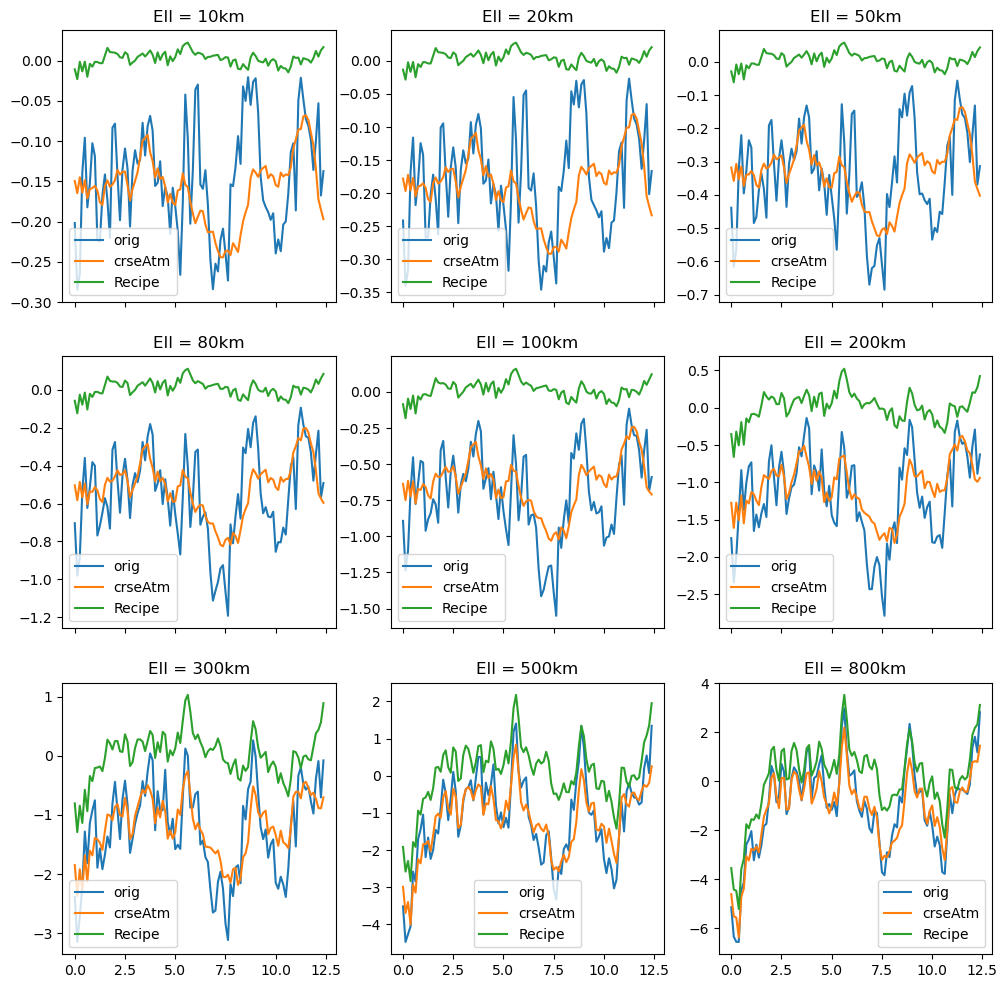

In [8]:
ndays = 100
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex=True)
for i in range(nell):
    ii = int(i//3)
    jj = int(i%3)
    ellIdx = i
    axes[ii, jj].plot(np.arange(ndays)/8, areaAvg_EPPA[ellIdx, 0:ndays]*1e3, label = 'orig')
    axes[ii, jj].plot(np.arange(ndays)/8, areaAvg_EPPA_crseAtm[ellIdx, 0:ndays]*1e3, label = 'crseAtm')
    axes[ii, jj].plot(np.arange(ndays)/8, areaAvg_EPPA_Recipe[ellIdx, 0:ndays]*1e3, label = 'Recipe')
    axes[ii, jj].legend()
    axes[ii,jj].set_title('Ell = '+str(ellList[i])+'km')
    

In [9]:
timeAreaAvg_EPPA = np.mean(areaAvg_EPPA, axis=1)
timeAreaAvg_EPPA_crseAtm = np.mean(areaAvg_EPPA_crseAtm, axis=1)
timeAreaAvg_EPPA_Recipe = np.mean(areaAvg_EPPA_Recipe, axis=1)

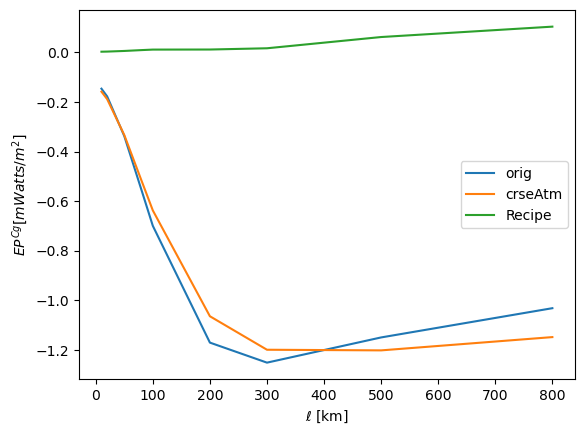

In [10]:
plt.plot(ellList, 1e3*timeAreaAvg_EPPA, label = 'orig')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_crseAtm, label = 'crseAtm')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_Recipe, label = 'Recipe')
plt.xlabel(r'$\ell$ [km]')
plt.ylabel(r'$EP^{Cg} [mWatts/m^2]$')
plt.legend()

In [11]:
maskKE_ds = Dataset('/pscratch/sd/s/srai/ROMSwithWRF/run/input/mask.nc')
maskKE = np.array(maskKE_ds.variables['highKEandEKEmask'][:,:])
maskKE[0:70,:] = 0
maskKE[:,0:70] = 0
maskKE[434-70:434,:] = 0
maskKE[:,1120-70:1120] = 0
print(maskKE.shape)

(434, 1120)


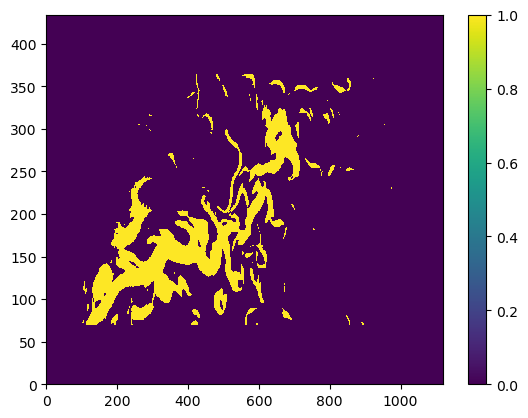

In [12]:
plt.pcolormesh(maskKE)
plt.colorbar()

In [13]:
areaAvg_EPPA_highKE = getAreaAvgEPPA(EPPA , UAREA, maskKE)
areaAvg_EPPA_crseAtm_highKE = getAreaAvgEPPA(EPPA_crseAtm , UAREA, maskKE)
areaAvg_EPPA_Recipe_highKE = getAreaAvgEPPA(EPPA_Recipe , UAREA, maskKE)

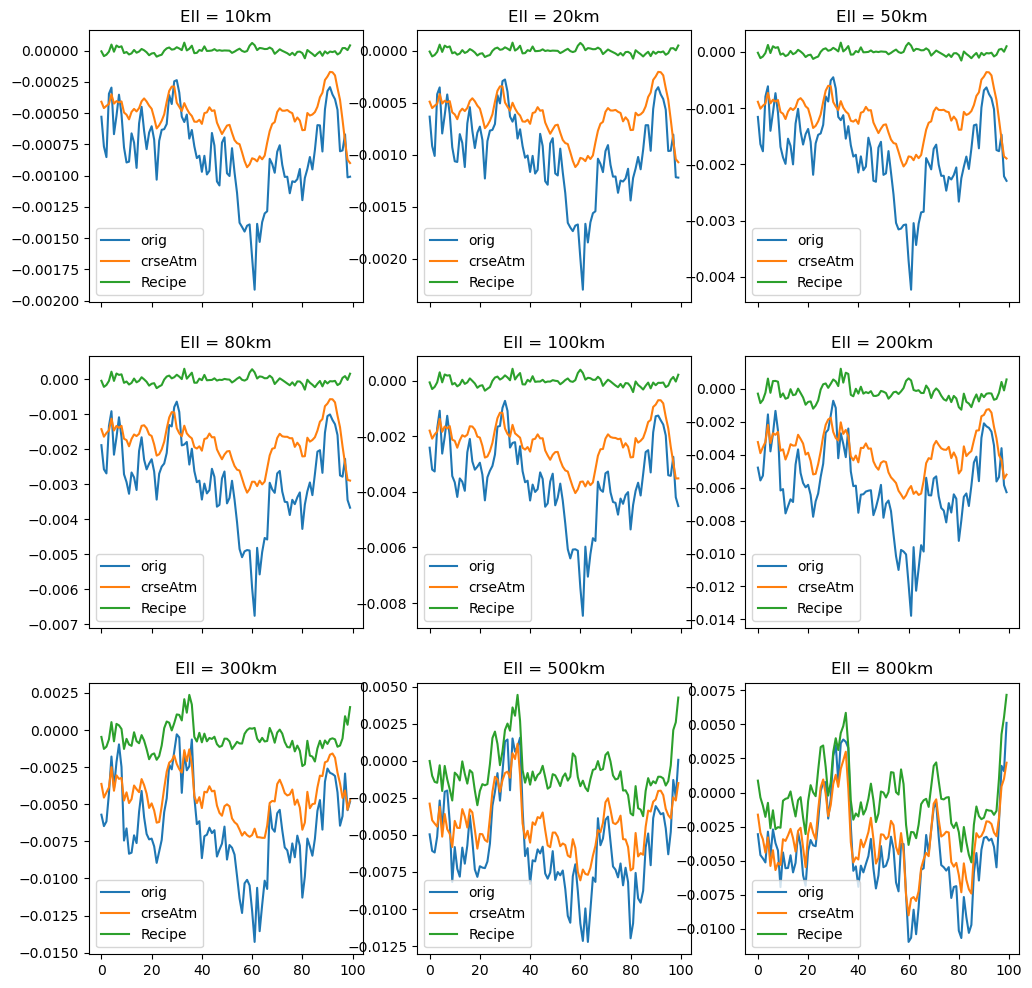

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex=True)
for i in range(nell):
    ii = int(i//3)
    jj = int(i%3)
    ellIdx = i
    axes[ii, jj].plot(areaAvg_EPPA_highKE[ellIdx, :], label = 'orig')
    axes[ii, jj].plot(areaAvg_EPPA_crseAtm_highKE[ellIdx, :], label = 'crseAtm')
    axes[ii, jj].plot(areaAvg_EPPA_Recipe_highKE[ellIdx, :], label = 'Recipe')
    axes[ii, jj].legend()
    axes[ii,jj].set_title('Ell = '+str(ellList[i])+'km')

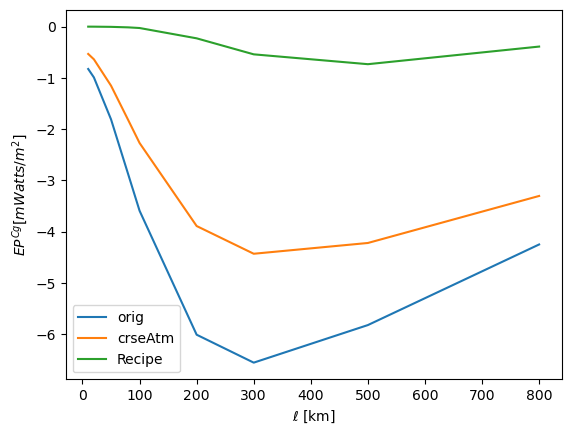

In [15]:
timeAreaAvg_EPPA_highKE = np.mean(areaAvg_EPPA_highKE, axis=1)
timeAreaAvg_EPPA_crseAtm_highKE = np.mean(areaAvg_EPPA_crseAtm_highKE, axis=1)
timeAreaAvg_EPPA_Recipe_highKE = np.mean(areaAvg_EPPA_Recipe_highKE, axis=1)

plt.plot(ellList, 1e3*timeAreaAvg_EPPA_highKE, label = 'orig')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_crseAtm_highKE, label = 'crseAtm')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_Recipe_highKE, label = 'Recipe')
plt.xlabel(r'$\ell$ [km]')
plt.ylabel(r'$EP^{Cg} [mWatts/m^2]$')
plt.legend()

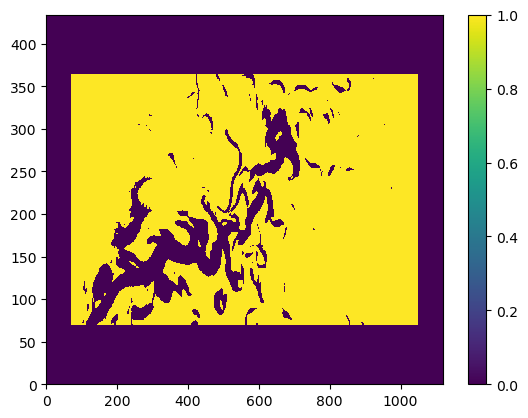

In [16]:
maskLowKE = 1 - maskKE
maskLowKE[0:70,:] = 0
maskLowKE[:,0:70] = 0
maskLowKE[434-70:434,:] = 0
maskLowKE[:,1120-70:1120] = 0

plt.pcolormesh(maskLowKE)
plt.colorbar()

In [17]:
areaAvg_EPPA_lowKE = getAreaAvgEPPA(EPPA , UAREA, maskLowKE)
areaAvg_EPPA_crseAtm_lowKE = getAreaAvgEPPA(EPPA_crseAtm , UAREA, maskLowKE)
areaAvg_EPPA_Recipe_lowKE = getAreaAvgEPPA(EPPA_Recipe , UAREA, maskLowKE)

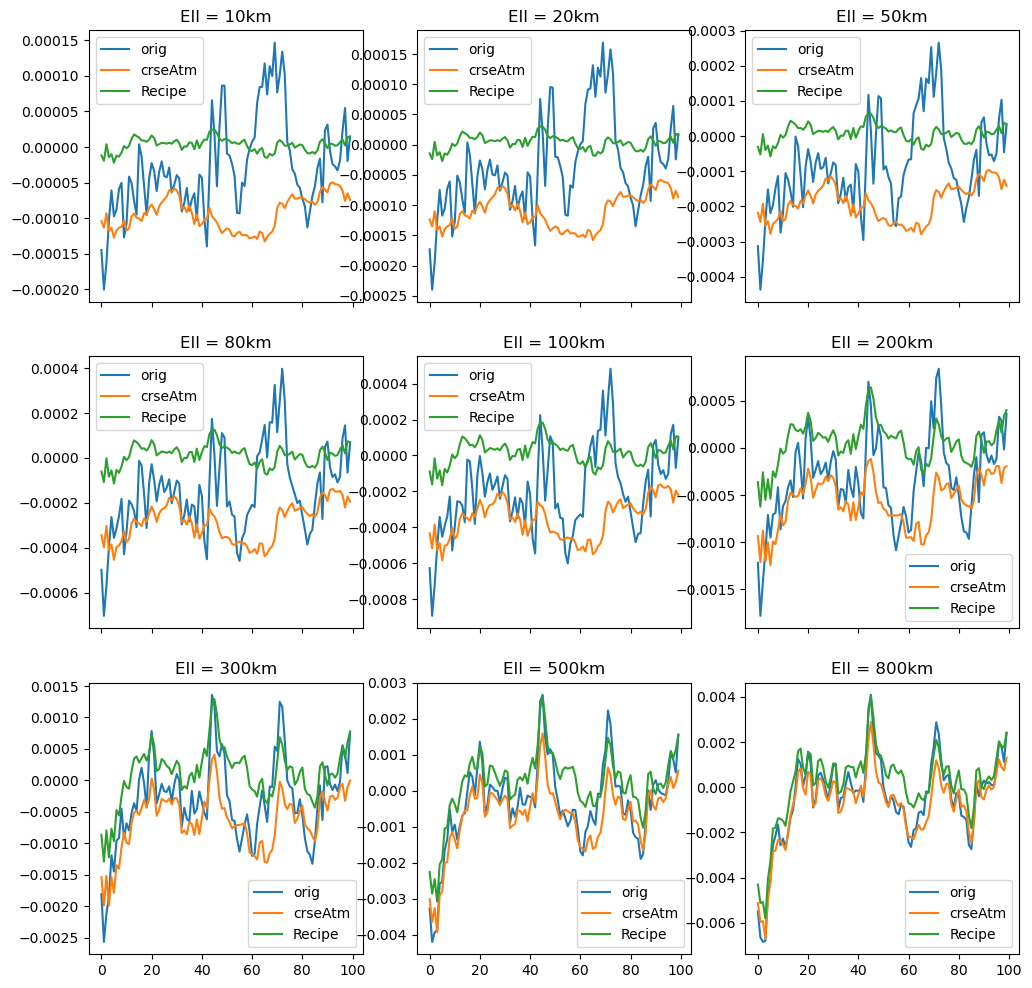

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex=True)
for i in range(nell):
    ii = int(i//3)
    jj = int(i%3)
    ellIdx = i
    axes[ii, jj].plot(areaAvg_EPPA_lowKE[ellIdx, :], label = 'orig')
    axes[ii, jj].plot(areaAvg_EPPA_crseAtm_lowKE[ellIdx, :], label = 'crseAtm')
    axes[ii, jj].plot(areaAvg_EPPA_Recipe_lowKE[ellIdx, :], label = 'Recipe')
    axes[ii, jj].legend()
    axes[ii,jj].set_title('Ell = '+str(ellList[i])+'km')

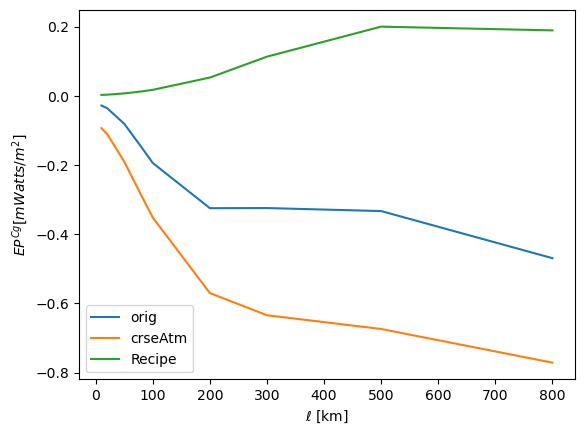

In [19]:
timeAreaAvg_EPPA_lowKE = np.mean(areaAvg_EPPA_lowKE, axis=1)
timeAreaAvg_EPPA_crseAtm_lowKE = np.mean(areaAvg_EPPA_crseAtm_lowKE, axis=1)
timeAreaAvg_EPPA_Recipe_lowKE = np.mean(areaAvg_EPPA_Recipe_lowKE, axis=1)

plt.plot(ellList, 1e3*timeAreaAvg_EPPA_lowKE, label = 'orig')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_crseAtm_lowKE, label = 'crseAtm')
plt.plot(ellList, 1e3*timeAreaAvg_EPPA_Recipe_lowKE, label = 'Recipe')
plt.xlabel(r'$\ell$ [km]')
plt.ylabel(r'$EP^{Cg} [mWatts/m^2]$')
plt.legend()

5 80


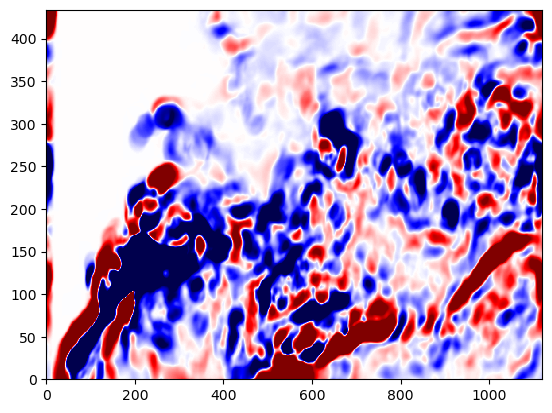

In [20]:
ellIdx = ellList.index(200)
dayIdx = 10*8
print(ellIdx, dayIdx)
v = 5
plt.pcolormesh(EPPA[ellIdx, dayIdx, :, :]*1e3, cmap='seismic', vmin=-v, vmax=v)

In [21]:
np.shape(EPPA)

(9, 100, 434, 1120)

In [22]:
fldLoc = '/pscratch/sd/s/srai/ROMSwithWRF/Downloaded/'
oGrdDs = Dataset(fldLoc + 'roms-natl1-grid_nolake.nc')
lon_u = np.array(oGrdDs.variables['lon_rho'])-360
lat_u = np.array(oGrdDs.variables['lat_rho'])
lat = np.linspace(np.min(lat_u), np.max(lat_u), 434)
lon = np.linspace(np.min(lon_u), np.max(lon_u), 1120)

NameError: name 'kmt' is not defined

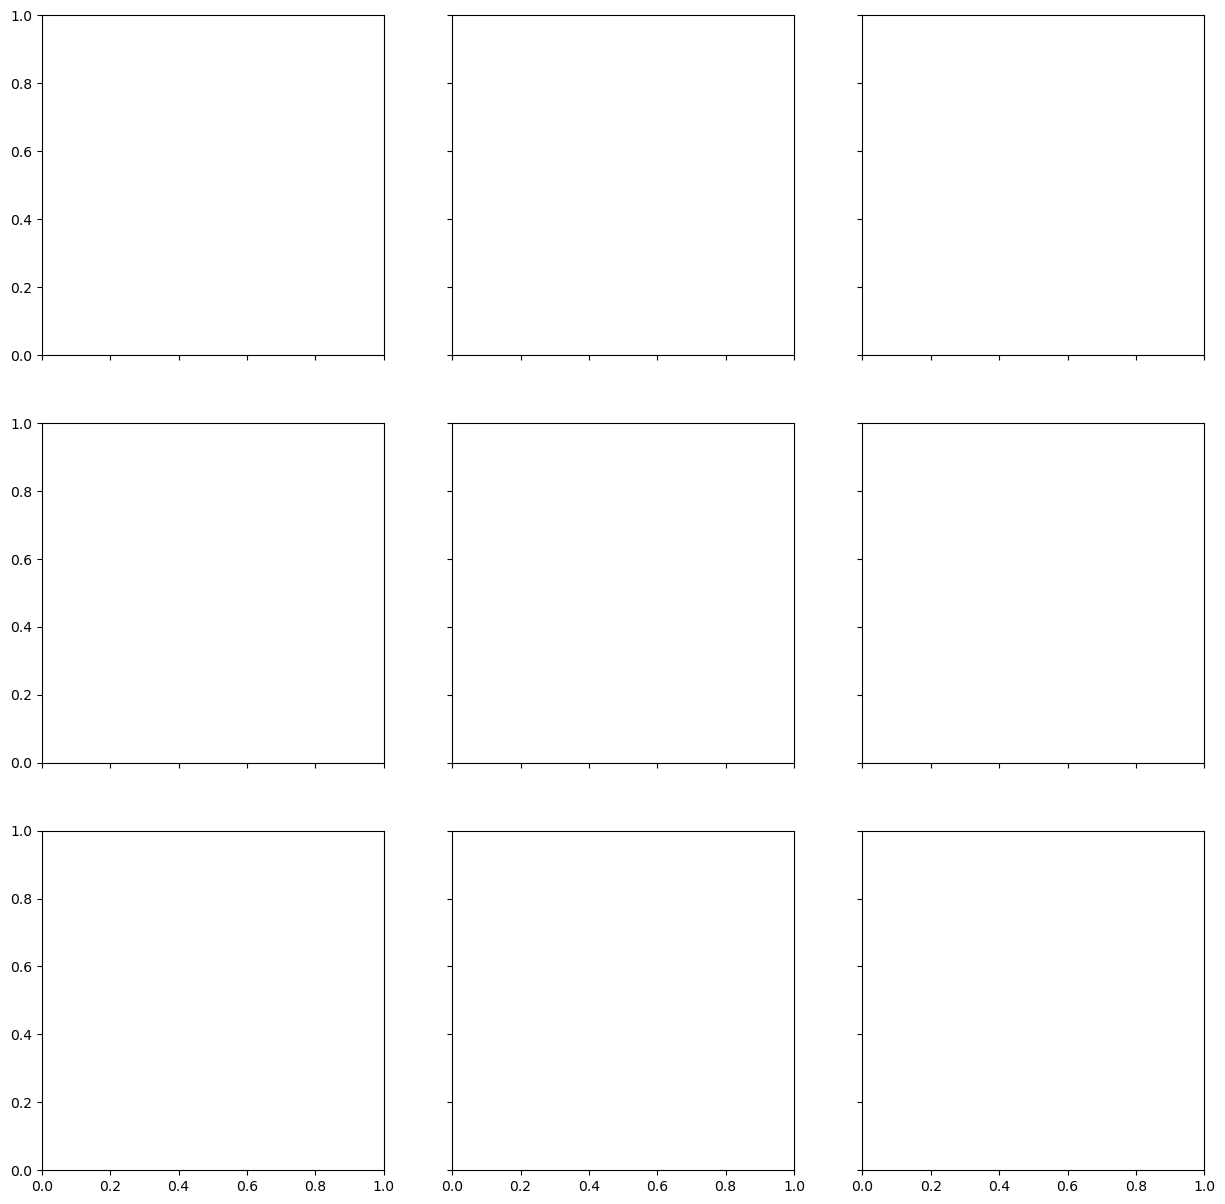

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex = True, sharey= True, figsize = (15,15))
c = 0
dayIdx = 0
v = 6
cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')
for i in range(3):
    for j in range(3):
        mskIdx = int((ellList[c]//7))
        pltArr = EPPA[c, dayIdx, :, :].copy()*1e3
        pltArr[kmt<1] = float('nan')
        pltArr[pltArr == 0] = float('nan')
        pltArr[0:mskIdx,:] = float('nan')
        pltArr[:,0:mskIdx] = float('nan')
        pltArr[434-mskIdx:434,:] = float('nan')
        pltArr[:,1120-mskIdx:1120] = float('nan')
        ax = axes[i,j]
        pmesh = ax.pcolormesh(lon, lat, pltArr, cmap=cmap, vmin=-v, vmax=v, rasterized=True)
        ax.set_title(r'EP at $\ell$ = {0:d} km'.format(ellList[c]))
        clb = plt.colorbar(pmesh, ax=ax)
        clb.ax.set_title(r'$mWatts/m^2$')
        c += 1
plt.savefig('firstDayhour3.pdf', dpi=100) 

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex = True, sharey= True, figsize = (15,15))
c = 0
v = 6
dayIdx = 99
cmap = plt.get_cmap('seismic').copy()
cmap.set_bad('k')
for i in range(3):
    for j in range(3):
        mskIdx = int((ellList[c]//7))
        pltArr = EPPA[c, dayIdx, :, :].copy()*1e3
        pltArr[kmt<1] = float('nan')
        pltArr[pltArr == 0] = float('nan')
        pltArr[0:mskIdx,:] = float('nan')
        pltArr[:,0:mskIdx] = float('nan')
        pltArr[434-mskIdx:434,:] = float('nan')
        pltArr[:,1120-mskIdx:1120] = float('nan')
        ax = axes[i,j]
        pmesh = ax.pcolormesh(lon, lat, pltArr, cmap=cmap, vmin=-v, vmax=v, rasterized=True)
        ax.set_title(r'EP at $\ell$ = {0:d} km'.format(ellList[c]))
        clb = plt.colorbar(pmesh, ax=ax)
        clb.ax.set_title(r'$mWatts/m^2$')
        c += 1
plt.savefig('TwelveDayhour12.pdf', dpi=100)         